# Energy data hack 
Challenge 1 : Interception des ondes radios sur les capteurs d’énergies


## Partie 3 : Analyse des modèles  

# Membres : 
- Maxence Brugères (Telecom Paris & Sciences Po)
- Clément Bernard (Telecom Paris & Polytechnique Montréal)
- Inès Benito (ENSTA Bretagne)
- Corentin Lestrat (ENSTA BRETAGNE)



![picture](https://github.com/clementbernardd/hackaton_ondes/raw/main/images/logo_hackaton.png)

# Importation of data and models 

In [1]:
# Obtention des données 
!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/Hackaton.zip
!unzip  Hackaton.zip
!rm Hackaton.zip

!mkdir models 
!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/models/gru.zip 
!unzip gru.zip  
!rm gru.zip
!mv gru /content/models 


!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/models/mlp.zip 
!unzip mlp.zip 
!rm mlp.zip
!mv mlp /content/models


!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/models_noise.zip
!unzip models_noise.zip
!rm models_noise.zip

!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/models_stack.zip
!unzip models_stack.zip
!rm models_stack.zip

!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/python.zip
!unzip python.zip
!rm python.zip

!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/models/rf_predictions.pkl
!mv rf_predictions.pkl /content/models

!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/models/rf_predictions_test.pkl
!mv rf_predictions_test.pkl /content/models




import sys
sys.path.append('/content/Hackaton/python')
sys.path.append('/content/python')
from read_pics import  * 
# Python file importations 
from gru import * 
from mlp import * 
from dataset import * 
from mlp_stack import *
from gru_noise import *  
from utils import * 

import os 
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn 
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import cross_validate, GridSearchCV

import pickle 
def load_obj(name ):
  with open(  name + '.pkl', 'rb') as f:
    return pickle.load(f)


# Device to use : either gpu or cpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

--2021-04-05 09:30:25--  https://github.com/clementbernardd/hackaton_ondes/raw/main/Hackaton.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/clementbernardd/hackaton_ondes/main/Hackaton.zip [following]
--2021-04-05 09:30:25--  https://raw.githubusercontent.com/clementbernardd/hackaton_ondes/main/Hackaton.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13275917 (13M) [application/zip]
Saving to: ‘Hackaton.zip’

Hackaton.zip        100%[===================>]  12.66M  35.6MB/s    in 0.4s    

2021-04-05 09:30:26 (35.6 MB/s) - ‘Hackaton.zip’ saved [13275917/13275917]

Archive:  Hackaton.zip


## Load the login and mdp

In [2]:
pics_login, info = get_pics_from_file(os.path.join('Hackaton', 'data','pics_LOGINMDP.bin'))

## Dictionnary to map the data into letters and classes

In [3]:
def letter_range(start, stop="{", step=1):
    for ord_ in range(ord(start.upper()), ord(stop.upper())+1, step):
        yield chr(ord_)
        
keys = ['NOKEY','0','1','2','3','4','5','6','7','8','9'] + list(letter_range("A", "Z")) + ['ENTER','CTRL','SHIFT','SPACE','SUPPR']
class_to_letter = {i : keys[i] for i in range(len(keys)) }
letter_to_class = {class_to_letter[i] : i for i in class_to_letter}
name_to_class = {'pics_'+letter+'.bin' : letter_to_class[letter] for letter in letter_to_class}

## Convert the data into X and Y 

In [4]:
def get_data(name_to_class = name_to_class) : 
  ''' Return training dataset '''
  data = []
  labels = []
  for name in name_to_class : 
    
    pics, info = get_pics_from_file(os.path.join('Hackaton','data', name))
    for trame in pics : 
      data.append(trame)
      labels.append(name_to_class[name])      

  return np.array(data), np.array(labels)

In [5]:
data, labels = get_data()

# 1. Unique frame 

## Separation into training and validation set 

In [6]:
# Data on all the dataset 
train_data, train_labels, validation_data, validation_labels = split_data(data, labels )

# Create pytorch dataset 

## Training and validation 

In [7]:
# Training pytorch loader 
data_train = Pics_Dataset(train_data, train_labels)
data_train_loader = DataLoader(data_train, batch_size=500, shuffle=True)

# Validation pytorch loader
data_validation = Pics_Dataset(validation_data, validation_labels)
data_validation_loader = DataLoader(data_validation, batch_size=500, shuffle=True)

# Pytorch loader for all the data
data_all = Pics_Dataset(data, labels)
data_all_loader = DataLoader(data_all, batch_size=500, shuffle = True )

## Multi-layer Perceptron 

In [8]:
mlp = MLP(input_dim = 17, hidden_dim = 2048 , output_size= 42, name = os.path.join('/content','models','mlp'))

In [9]:
mlp.load_checkpoint()

--- Loading model checkpoint ---


## Gated Recurrent Unit (GRU)

In [10]:
gru = GRU(input_dim=17, embed_dim = 128,hidden_dim=512, output_size=42, name = os.path.join('/content','models','gru'))

In [11]:
gru.load_checkpoint()

--- Loading model checkpoint ---


# Random Forest 

In [77]:
rf_preds = load_obj(os.path.join('/content','models','rf_predictions'))
rf_preds_test = load_obj(os.path.join('/content','models','rf_predictions_test'))

# 2. Group of frames 

## Without noise 

### Functions to group the trames by group 

In [20]:
data_stack = {i : stack_trames_labels(data, labels, N = i) for i in [1,5, 10, 25, 50, 100, 200]}

### Get training and validation data 

In [21]:
all_data_stack = {i : split_data(data_stack[i][0],data_stack[i][1] ) for i in data_stack}

In [22]:
# Data stack 
train_data_stack = {i : all_data_stack[i][0] for i in all_data_stack}
train_labels_stack = {i : all_data_stack[i][1] for i in all_data_stack}
validation_data_stack = {i : all_data_stack[i][2] for i in all_data_stack}
validation_labels_stack = {i : all_data_stack[i][3] for i in all_data_stack}


In [23]:
# Train data 
data_train_stack = {i : Pics_Dataset(train_data_stack[i], train_labels_stack[i]) for i in train_data_stack}
data_train_loader_stack = {i : DataLoader(data_train_stack[i], batch_size=500, shuffle=True) for i in data_train_stack}

# Validation data
data_validation_stack = {i : Pics_Dataset(validation_data_stack[i], validation_labels_stack[i]) for i in validation_data_stack}
data_validation_loader_stack = {i : DataLoader(data_validation_stack[i], batch_size=500, shuffle=True) for i in data_validation_stack}

# # All the data 
data_all_stack = {i : Pics_Dataset(data_stack[i][0], data_stack[i][1]) for i in data_stack}
data_all_loader_stack = {i : DataLoader(data_all_stack[i], batch_size=500, shuffle = True) for i in data_all_stack}


## Multi-layer Perceptron Stack (for group of frames)

In [24]:
# Get a model for each group of frames 
mlp_stack = {i : MLP_STACK(input_dim = i , hidden_dim = 512 , output_size= 42, name =os.path.join('/content','models_stack','mlp_stack_'+str(i)) ) for i in all_data_stack}

In [25]:
for i in mlp_stack : 
  mlp_stack[i].load_checkpoint()

--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---


## GRU Stack (for group of frames)

In [26]:
gru_model_stack = {i : GRU_NOISE(input_dim=i, embed_dim = None ,hidden_dim=256, output_size=42, name = \
                                 os.path.join('/content','models_stack','gru_stack_'+str(i))) for i in all_data_stack}

In [27]:
for i in gru_model_stack : 
  gru_model_stack[i].load_checkpoint()

--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---


## With noise 

### Functions that create noise

In [28]:
data, labels = get_data()
data_stack = {i : stack_trames_labels(data, labels, N = i) for i in [1,5, 10, 25, 50, 100, 200]}

In [29]:
data_noise = {i : add_noise( data_stack[i][0], data_stack[i][1], coeff = 100, n_frames = i  ) for i in data_stack}

In [30]:
all_data_noise = {i : split_data(data_noise[i][0],data_noise[i][1] ) for i in data_noise}

In [31]:
# Split into training and validation sets 
train_data_noise = {i : all_data_noise[i][0] for i in all_data_noise}
train_labels_noise = {i : all_data_noise[i][1] for i in all_data_noise}
validation_data_noise = {i : all_data_noise[i][2] for i in all_data_noise}
validation_labels_noise = {i : all_data_noise[i][3] for i in all_data_noise}

### Create pytorch dataset 

In [32]:
# Train data 
data_train_noise = {i : Pics_Dataset(train_data_noise[i], train_labels_noise[i]) for i in train_data_noise}
data_train_loader_noise = {i : DataLoader(data_train_noise[i], batch_size=500, shuffle=True) for i in data_train_noise}

# Validation data
data_validation_noise = {i : Pics_Dataset(validation_data_noise[i], validation_labels_noise[i]) for i in validation_data_noise}
data_validation_loader_noise = {i : DataLoader(data_validation_noise[i], batch_size=500, shuffle=True) for i in data_validation_noise}

# All the data 
data_all_noise = {i : Pics_Dataset(data_noise[i][0], data_noise[i][1]) for i in data_noise}
data_all_loader_noise = {i : DataLoader(data_all_noise[i], batch_size=500, shuffle = True) for i in data_all_noise}

## MLP Model noise

In [33]:
mlp_noise = {i : MLP_STACK(input_dim = i , hidden_dim = 512 , output_size= 42,\
                           name =os.path.join('/content','models_noise','mlp_noise_'+str(i))) for i in all_data_noise}


In [34]:
for i in mlp_noise : 
  mlp_noise[i].load_checkpoint()

--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---


## GRU Noise


In [35]:
gru_model_noise = {i : GRU_NOISE(input_dim=i, embed_dim = None ,hidden_dim=256, output_size=42, name =\
                                 os.path.join('/content','models_noise','gru_noise_'+str(i))) for i in all_data_noise}

In [36]:
for i in gru_model_noise : 
  gru_model_noise[i].load_checkpoint()

--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---


# Analyse of the models 

## 1. Trame unique 

## Predictions on validation sets 

In [37]:
# Hard prediction
all_y_validation = {'MLP' : get_prediction_all_dataset(mlp, data_validation_loader, device = device),\
                    'GRU' : get_prediction_all_dataset(gru, data_validation_loader,device = device ),\
                    'Random Forest' : [rf_preds['y_pred'], rf_preds['y_true']]}

In [38]:
rf_preds['y_true']

array([21,  3,  5, ..., 37, 13, 38])

In [39]:
rf_preds

{'y_pred': array([19,  5,  5, ..., 37, 13, 38]),
 'y_proba': array([[3.03117238e-02, 1.45988214e-04, 2.02149147e-04, ...,
         9.33220939e-04, 5.35702059e-05, 1.12944352e-04],
        [9.85490471e-03, 4.53957318e-04, 2.18864263e-01, ...,
         6.48242233e-04, 2.39109994e-05, 2.64795852e-04],
        [9.70397132e-03, 3.08568262e-04, 2.40415959e-01, ...,
         5.30257828e-04, 1.53861876e-05, 1.62746427e-04],
        ...,
        [5.63769458e-04, 1.93419492e-04, 7.60403937e-02, ...,
         4.22107941e-05, 3.18268619e-06, 7.59248176e-03],
        [7.01909124e-03, 4.78457166e-05, 6.68363401e-04, ...,
         1.05678310e-05, 4.24111245e-04, 2.22308363e-05],
        [3.44772535e-03, 2.22421779e-05, 1.96604739e-05, ...,
         1.42831672e-04, 1.67686027e-05, 2.82303147e-05]]),
 'y_true': array([21,  3,  5, ..., 37, 13, 38])}

In [40]:
# Get the confusion matrix 
conf_matrix = {name : confusion_matrix(all_y_validation[name][0],all_y_validation[name][1], normalize = 'true') for name in all_y_validation }

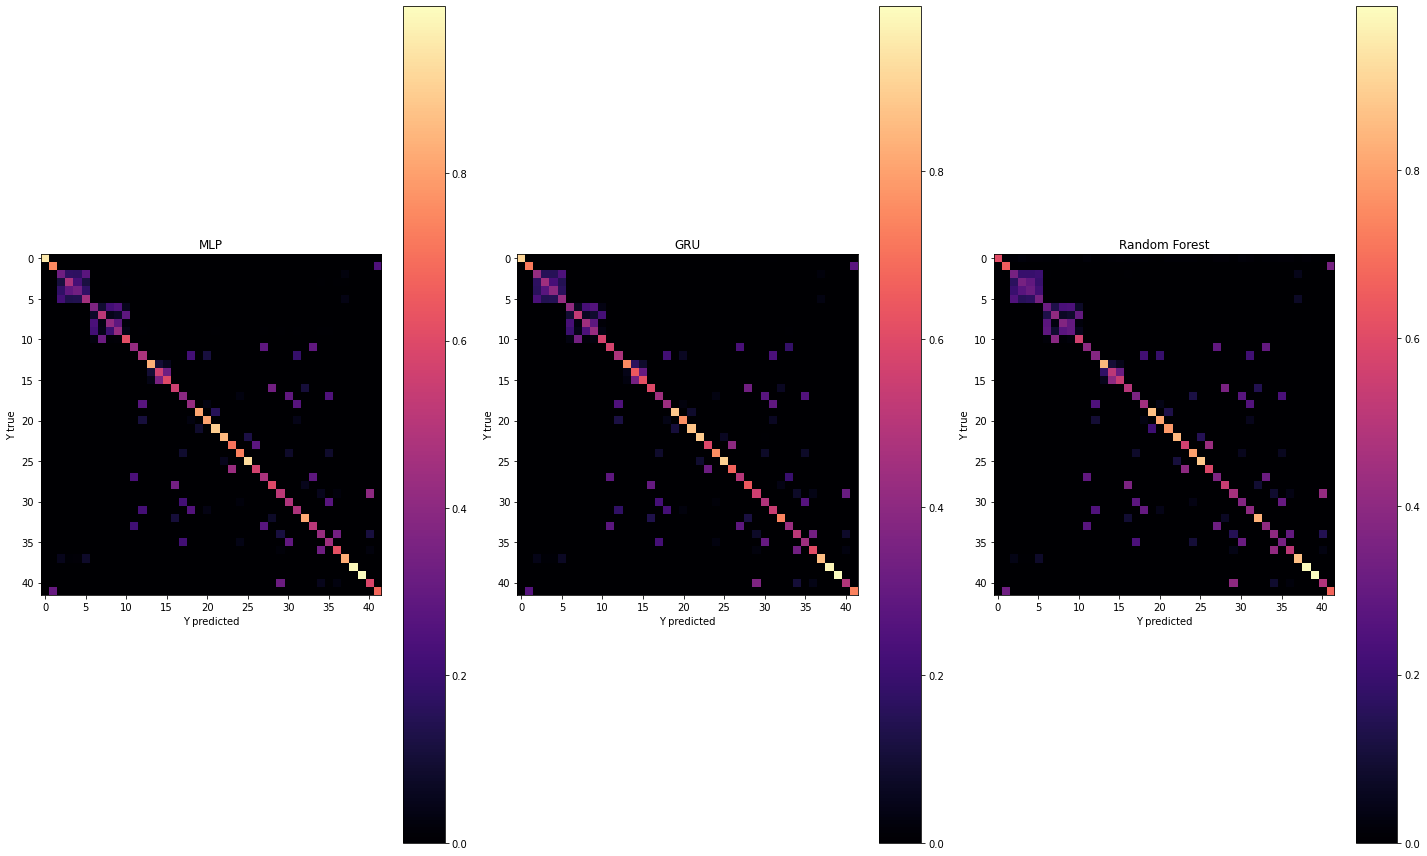

In [82]:
plot_mulitple_confusion_matrix(list_confusion = list(conf_matrix.values()),\
                               names = ['{}'.format(i) for i in conf_matrix],nrows = 1 ,ncols = 3)

## Get accuracy and f1 score on validation sets 

In [42]:
all_acc = { name : get_accuracy_digits(all_y_validation[name][1],all_y_validation[name][0], metric = accuracy_score ) for name in all_y_validation}
all_f1 = { name : get_accuracy_digits(all_y_validation[name][1],all_y_validation[name][0], metric = f1_score ) for name in all_y_validation}

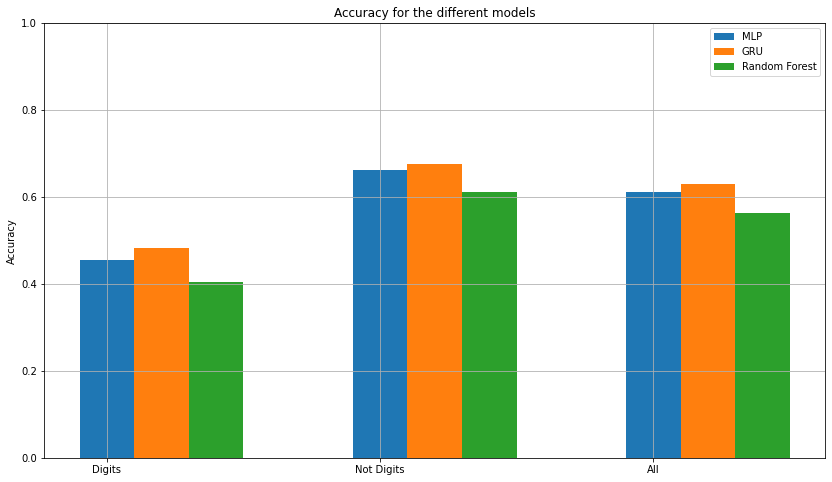

In [43]:
# Accuracy for the digits, not digits and all 
plot_chart_bart_score(all_acc, name = 'Accuracy')

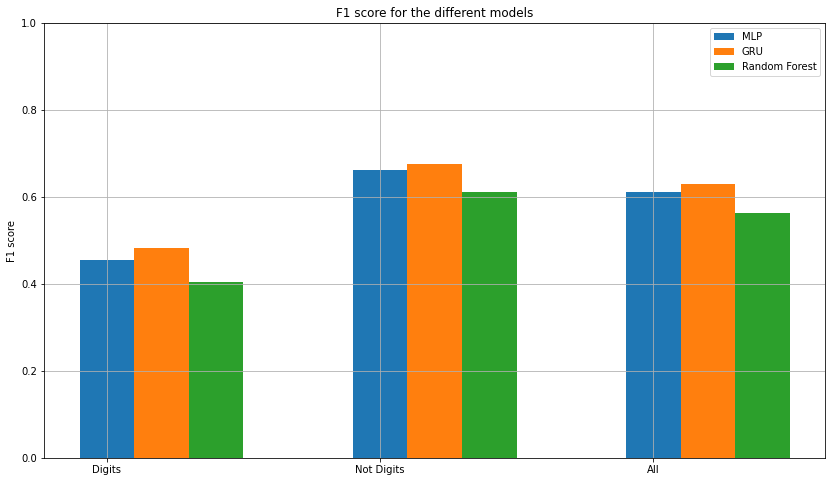

In [44]:
# Accuracy for the digits, not digits and all 
plot_chart_bart_score(all_f1, name = 'F1 score')

# 2. Group of frames 

## A. Without noise 

In [45]:
''' Prediction on the validation set '''

y_validation_gru_stack = {i : get_prediction_all_dataset(gru_model_stack[i], data_validation_loader_stack[i],device = device) for i in gru_model_stack}
y_validation_mlp_stack = {i : get_prediction_all_dataset(mlp_stack[i], data_validation_loader_stack[i],device = device) for i in mlp_stack}

### Confustion matrix 

In [46]:
''' GRU STACK '''
conf_gru_stack = {i : confusion_matrix( y_validation_gru_stack[i][1],y_validation_gru_stack[i][0], normalize = 'true') for i in y_validation_gru_stack}
''' MLP STACK '''
conf_mlp_stack = {i : confusion_matrix( y_validation_mlp_stack[i][1],y_validation_mlp_stack[i][0], normalize = 'true') for i in y_validation_mlp_stack}

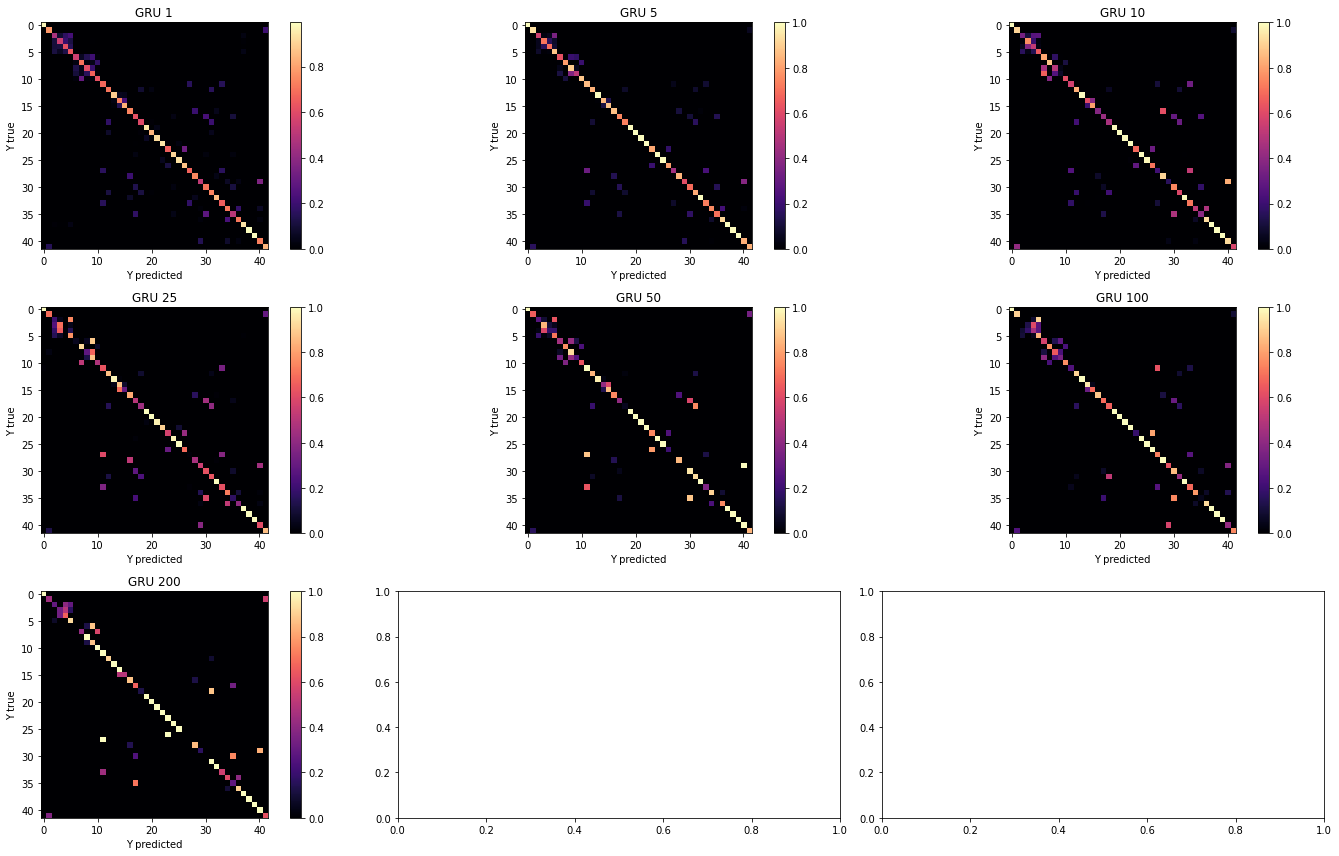

In [47]:
plot_mulitple_confusion_matrix(list_confusion = list(conf_gru_stack.values()),\
                               names = ['GRU {}'.format(i) for i in conf_gru_stack],nrows = 3 ,ncols = 3)

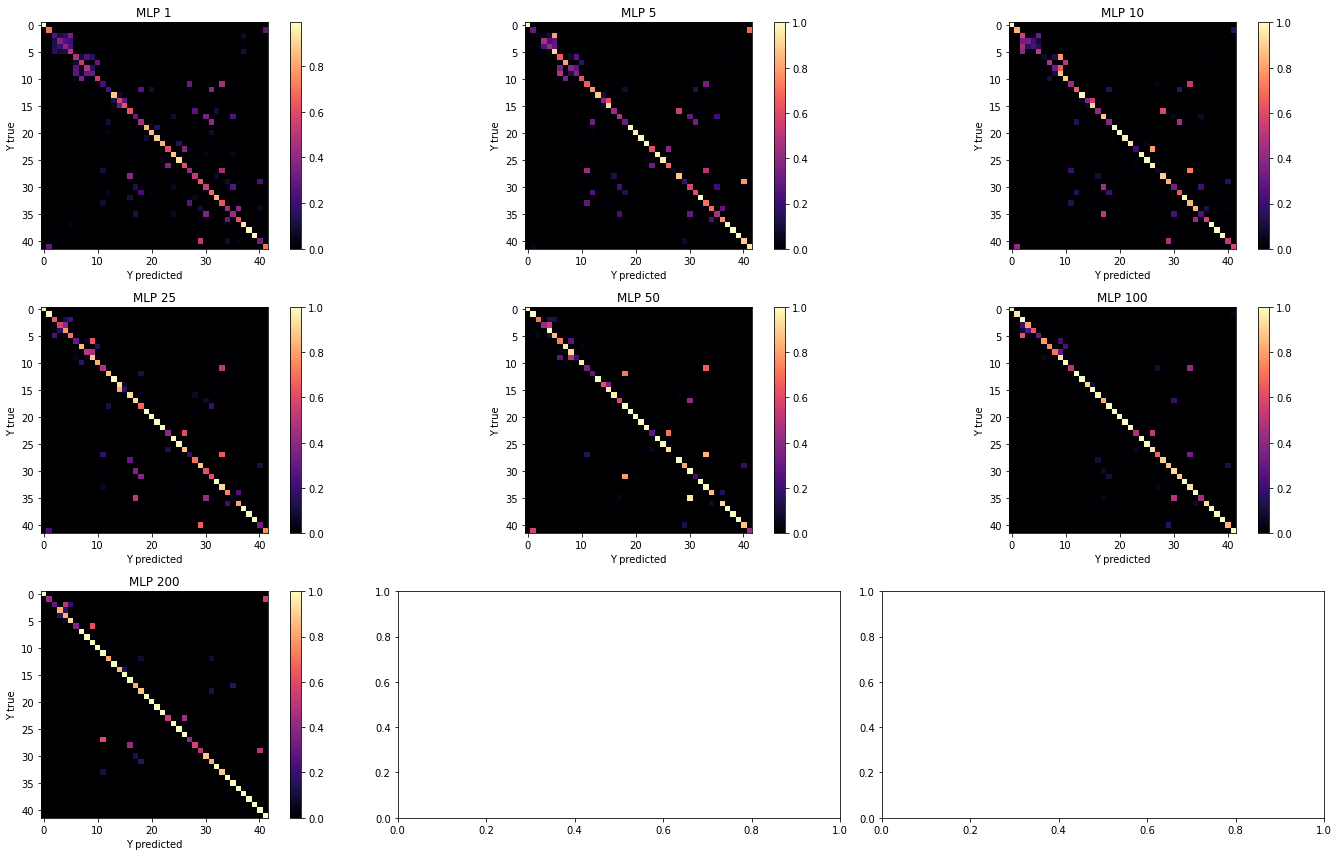

In [48]:
plot_mulitple_confusion_matrix(list_confusion = list(conf_mlp_stack.values()),\
                               names = ['MLP {}'.format(i) for i in conf_mlp_stack],nrows = 3 ,ncols = 3)

In [49]:
f1_score_gru_stack = { name : get_accuracy_digits(y_validation_gru_stack[name][1],y_validation_gru_stack[name][0], metric = f1_score ) for name in y_validation_gru_stack}
f1_score_mlp_stack = { name : get_accuracy_digits(y_validation_mlp_stack[name][1],y_validation_mlp_stack[name][0], metric = f1_score ) for name in y_validation_mlp_stack}

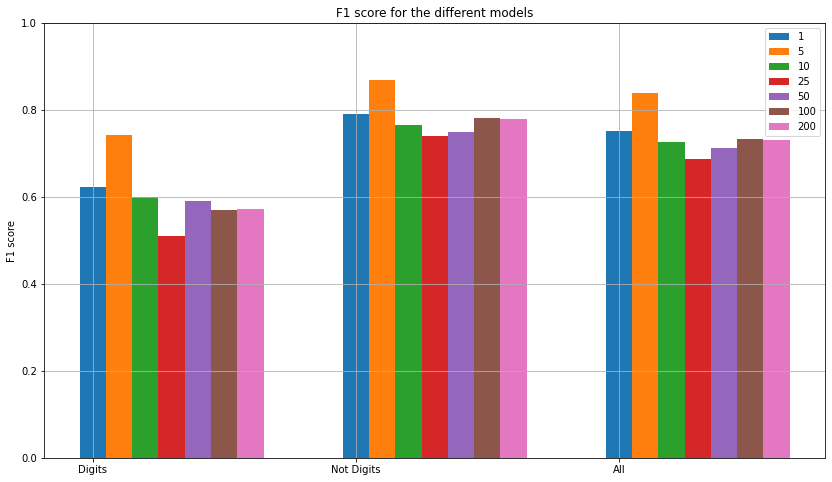

In [50]:
# Accuracy for the digits, not digits and all 
plot_chart_bart_score(f1_score_gru_stack, name = 'F1 score', width_ = 0.1)

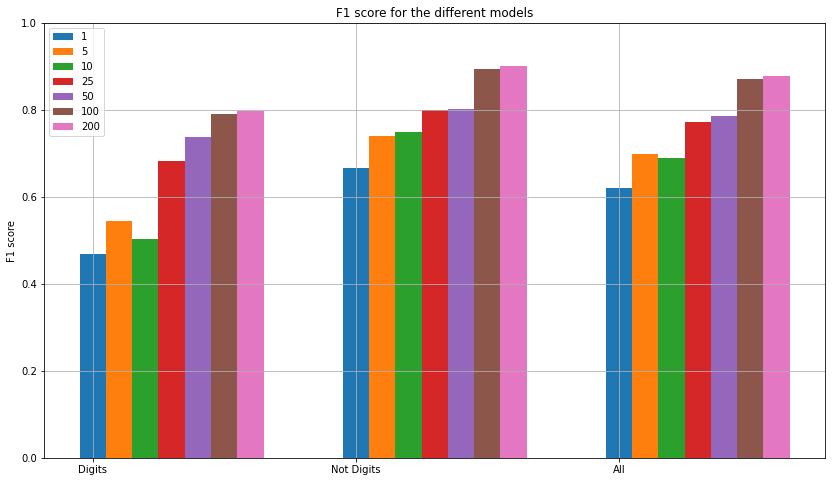

In [51]:
# Accuracy for the digits, not digits and all 
plot_chart_bart_score(f1_score_mlp_stack, name = 'F1 score', width_ = 0.1)

## B. With noise

In [89]:
''' Prediction on the validation set '''
y_validation_gru_noise = {i : get_prediction_all_dataset(gru_model_noise[i], data_validation_loader_stack[i],\
                                                         device = device) for i in gru_model_noise}
y_validation_mlp_noise = {i : get_prediction_all_dataset(mlp_noise[i], data_validation_loader_stack[i], device = device) for i in mlp_noise}

### Confustion matrix 

In [90]:
''' GRU STACK '''
conf_gru_noise = {i : confusion_matrix( y_validation_gru_noise[i][1],y_validation_gru_stack[i][0], normalize = 'true') for i in y_validation_gru_noise}
''' MLP STACK '''
conf_mlp_noise = {i : confusion_matrix( y_validation_mlp_noise[i][1],y_validation_gru_stack[i][0], normalize = 'true') for i in y_validation_mlp_noise}

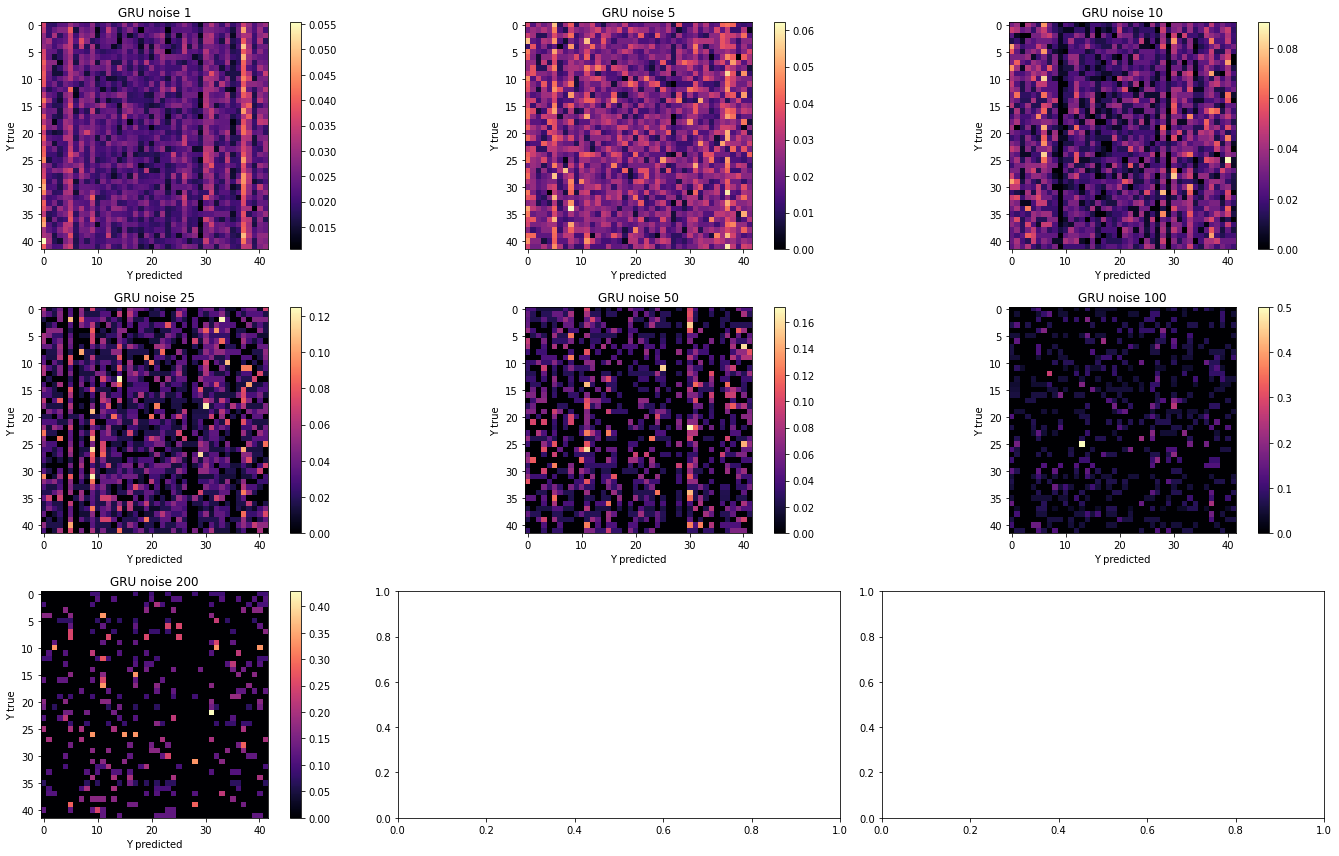

In [91]:
plot_mulitple_confusion_matrix(list_confusion = list(conf_gru_noise.values()),\
                               names = ['GRU noise {}'.format(i) for i in conf_gru_noise],nrows = 3 ,ncols = 3)

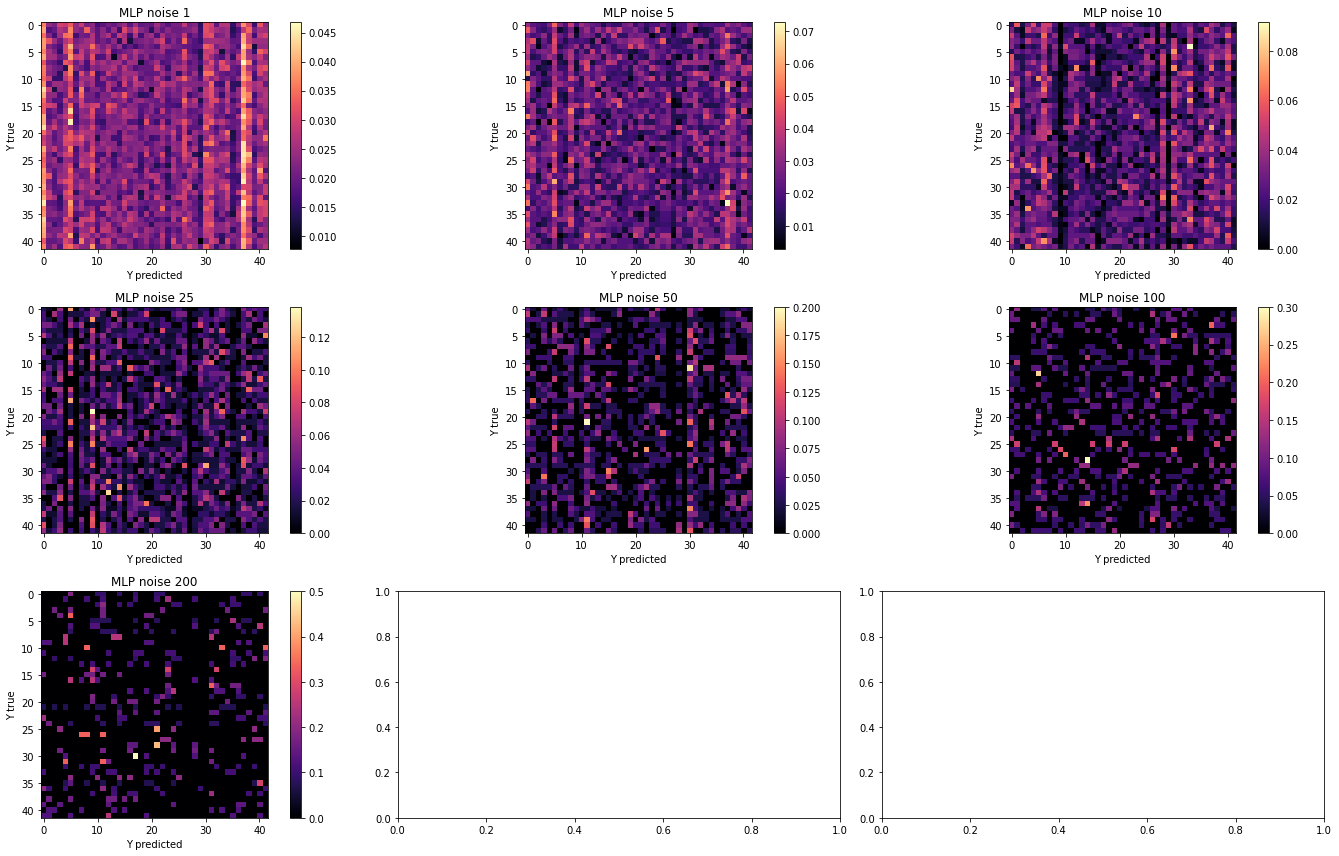

In [92]:
plot_mulitple_confusion_matrix(list_confusion = list(conf_mlp_noise.values()),\
                               names = ['MLP noise {}'.format(i) for i in conf_mlp_noise],nrows = 3 ,ncols = 3)

In [93]:
f1_score_gru_noise = { name : get_accuracy_digits(y_validation_gru_noise[name][1],y_validation_gru_noise[name][0], metric = f1_score ) for name in y_validation_gru_noise}
f1_score_mlp_noise = { name : get_accuracy_digits(y_validation_mlp_noise[name][1],y_validation_mlp_noise[name][0], metric = f1_score ) for name in y_validation_mlp_noise}

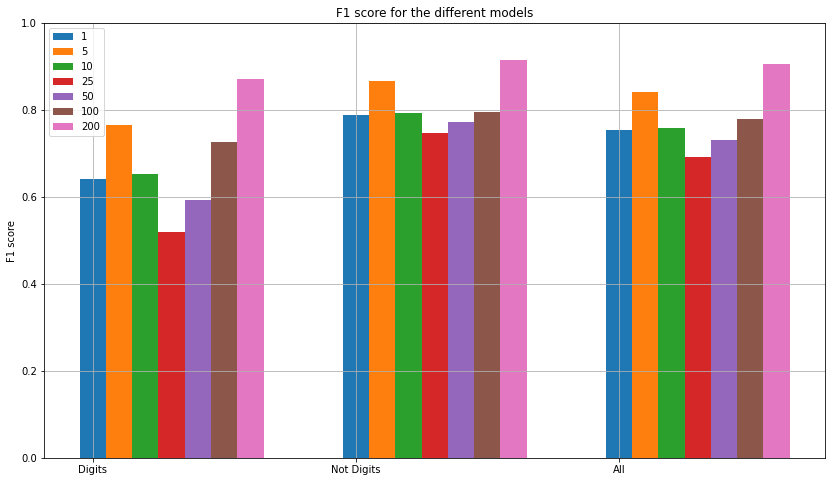

In [94]:
# Score for the digits, not digits and all 
plot_chart_bart_score(f1_score_gru_noise, name = 'F1 score', width_ = 0.1)

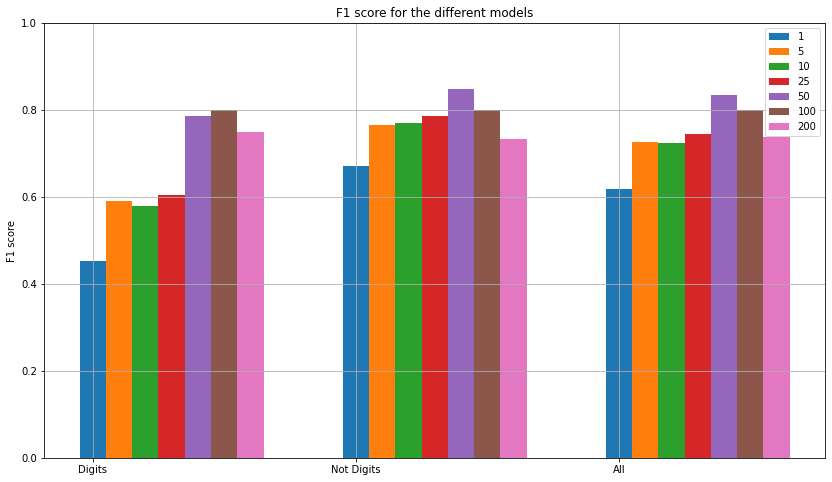

In [95]:
# Score for the digits, not digits and all 
plot_chart_bart_score(f1_score_mlp_noise, name = 'F1 score', width_ = 0.1)

# Prediction on the testing set (with login and mdp)

In [96]:
login_frames = {i : np.array(stack_trames(np.array(pics_login), N = i)) for i in data_all_stack}

# 1. Trame unique 

In [97]:
y_test_all = {}
''' GRU '''
y_test_all['GRU'] = torch.argmax(gru(torch.from_numpy(np.array(pics_login)).to(device)), axis = 1).detach().cpu().numpy()
''' MLP '''
y_test_all['MLP'] = torch.argmax(mlp(torch.from_numpy(np.array(pics_login)).to(device)), axis = 1).detach().cpu().numpy()
''' RANDOM FOREST '''
y_test_all['Random Forest'] = rf_preds_test['y_test']

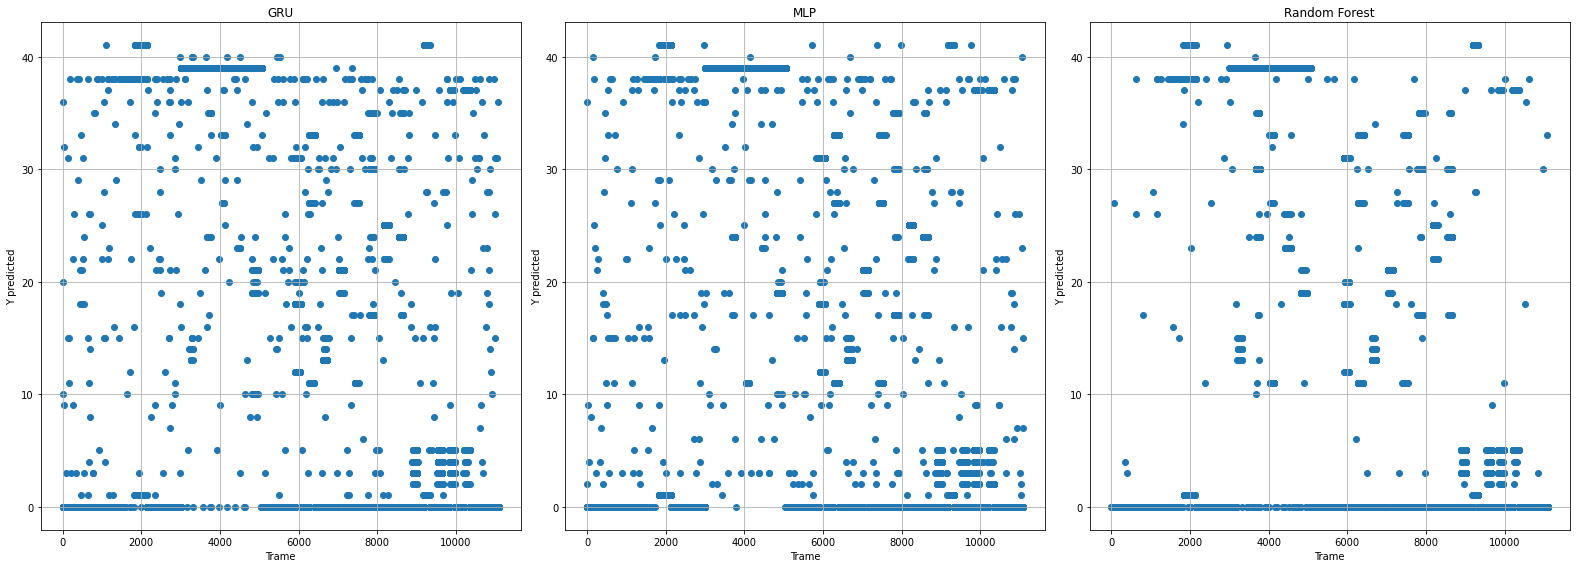

In [98]:
plot_multiple_predictions(y_preds = list(y_test_all.values()), names = list(y_test_all.keys()))

## Probability 

In [99]:
y_test_all_proba = {}
''' GRU '''
y_test_all_proba['GRU'] = nn.Softmax(dim = 1)(gru(torch.from_numpy(np.array(pics_login)).to(device))).detach().cpu().numpy()
''' MLP '''
y_test_all_proba['MLP'] = nn.Softmax(dim = 1)(mlp(torch.from_numpy(np.array(pics_login)).to(device))).detach().cpu().numpy()
''' Transformer '''
y_test_all_proba['RANDOM FOREST'] = rf_preds_test['y_test_proba']

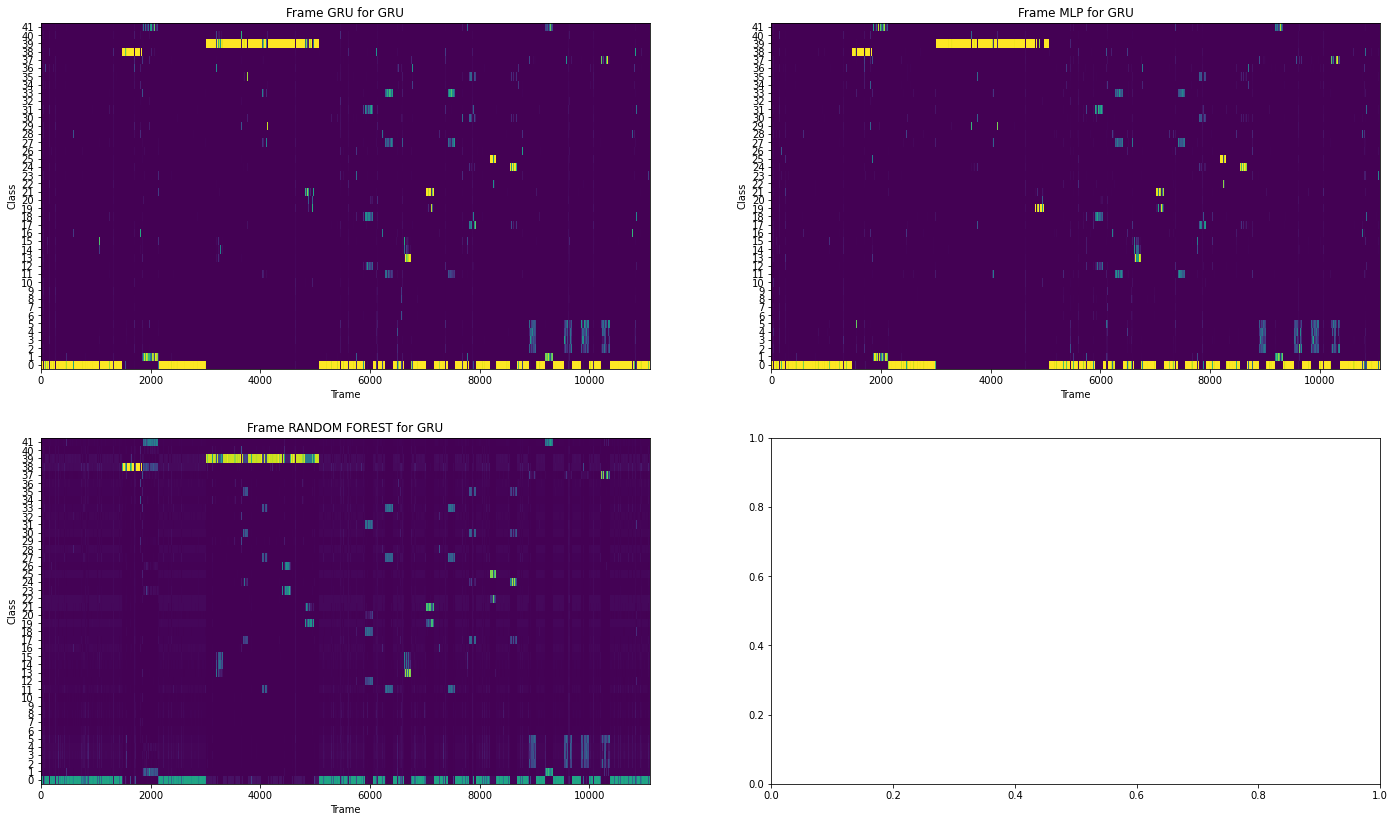

In [100]:
plot_proba(y_test_all_proba,nrows = 2, ncols = 2)

## 2. Group of frames 

### Without noise

#### Predictions 

In [64]:
y_tests_mlp_stack = {i : torch.argmax(mlp_stack[i](torch.from_numpy(login_frames[i]).to(device)), axis = 1).detach().cpu().numpy()\
                     for i in login_frames}
y_tests_gru_stack = {i : torch.argmax(gru_model_stack[i](torch.from_numpy(login_frames[i]).to(device)), axis = 1).detach().cpu().numpy()\
                     for i in login_frames}

#### Probability 

In [65]:
y_tests_mlp_stack_proba = {i : (nn.Softmax(dim = 1)(mlp_stack[i](torch.from_numpy(login_frames[i]).to(device))))\
                           .detach().cpu().numpy() for i in login_frames}
y_tests_gru_stack_proba = {i : (nn.Softmax(dim = 1)(gru_model_stack[i](torch.from_numpy(login_frames[i]).to(device))))\
                           .detach().cpu().numpy() for i in login_frames}


### MLP 

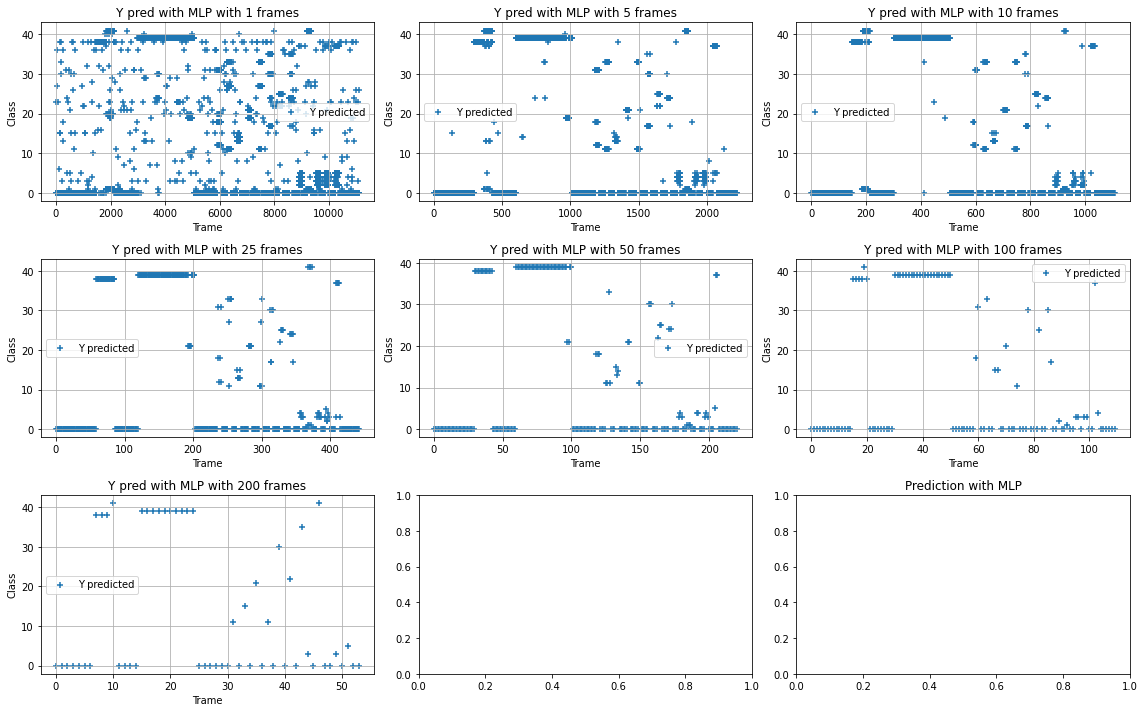

In [66]:
plot_multiple_prediction(y_tests_mlp_stack, nrows = 3, ncols=3, name = 'MLP')

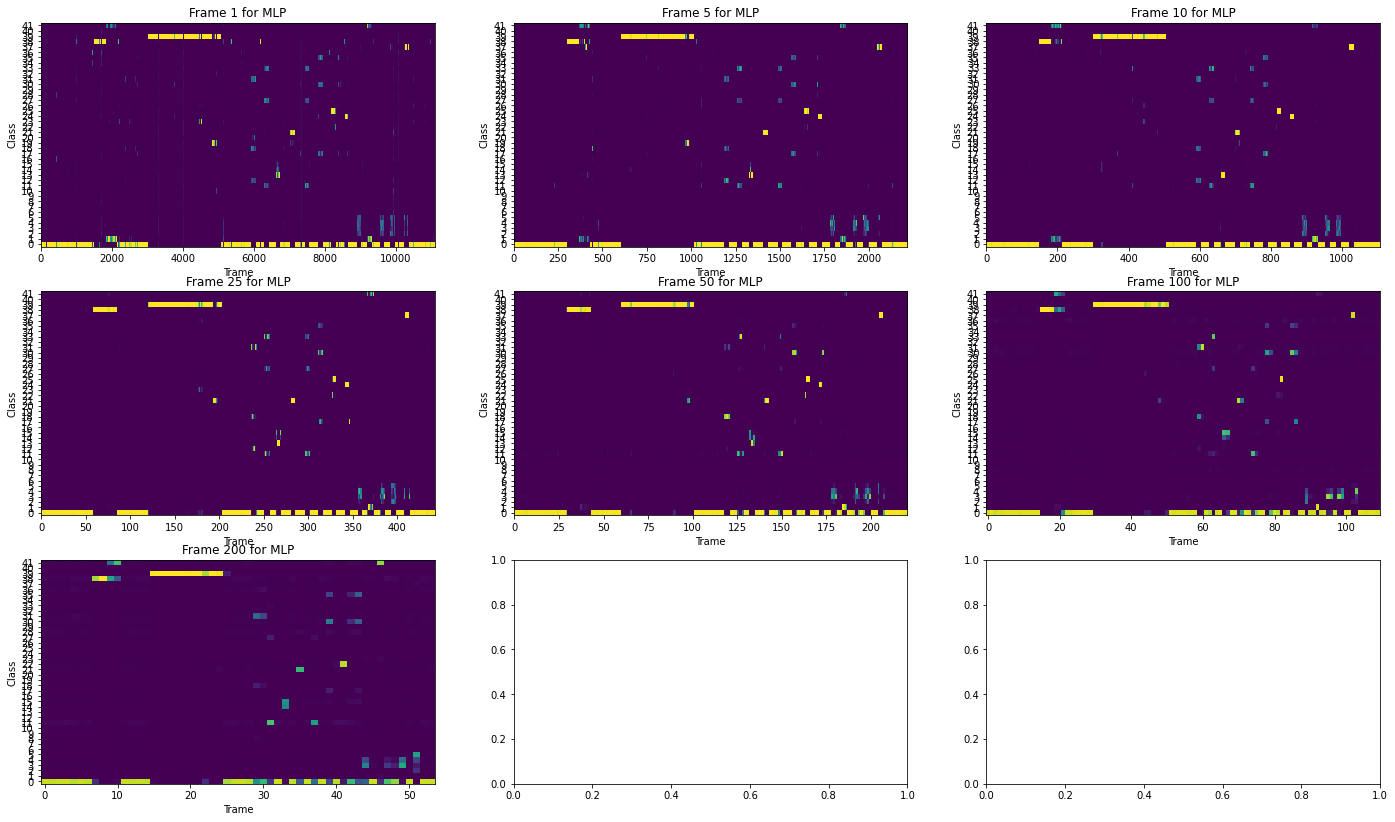

In [67]:
plot_proba(y_tests_mlp_stack_proba, nrows = 3, ncols = 3, name = 'MLP')

### GRU 

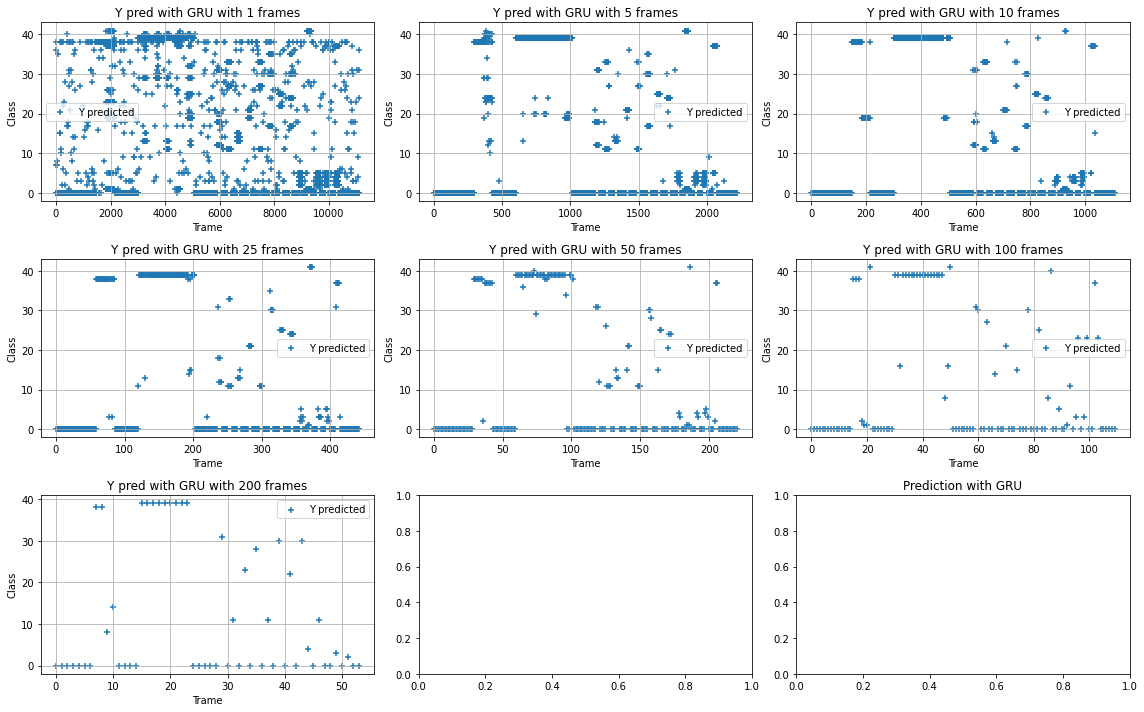

In [68]:
plot_multiple_prediction(y_tests_gru_stack, nrows = 3, ncols=3, name = 'GRU')

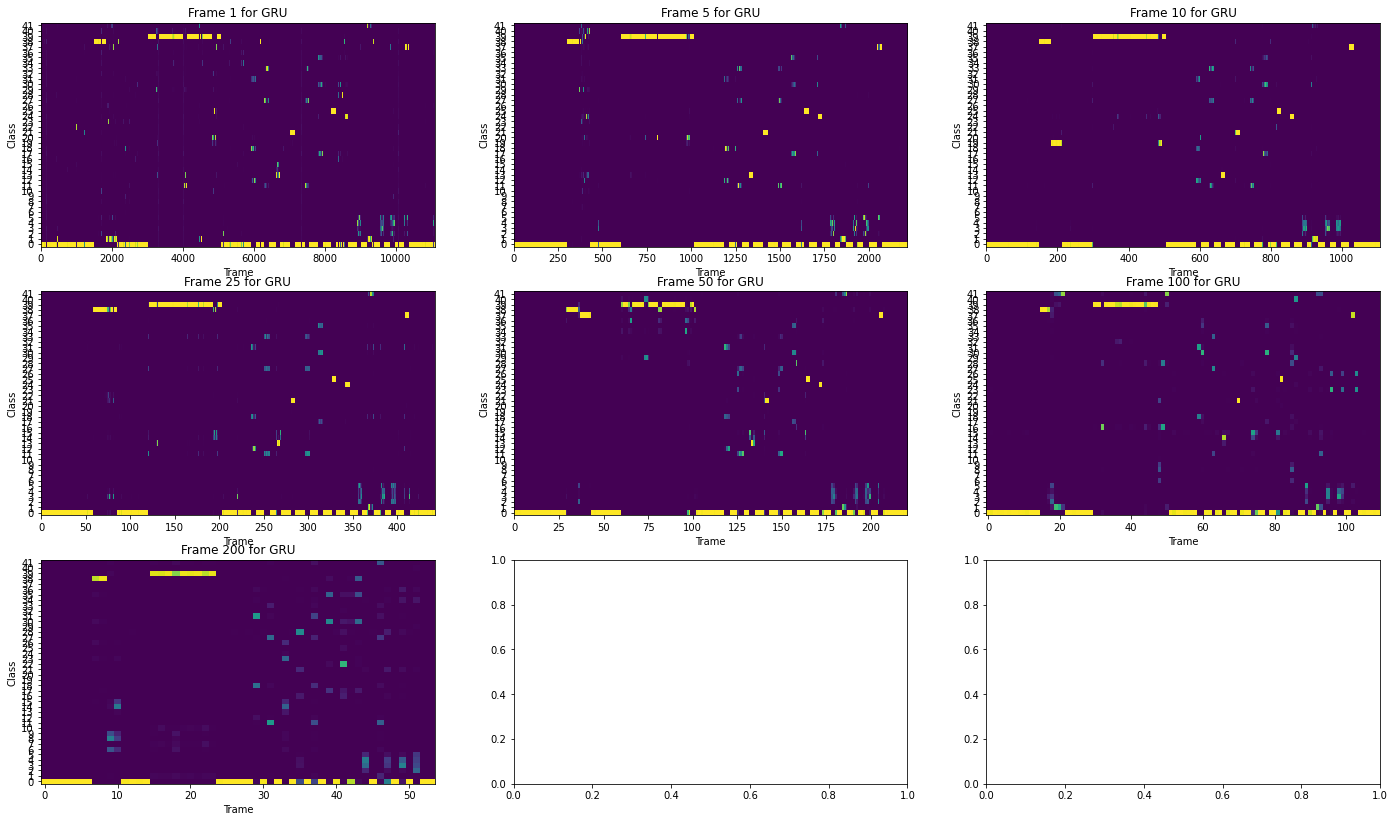

In [69]:
plot_proba(y_tests_gru_stack_proba, nrows = 3, ncols = 3, name = 'GRU')

### With noise

#### Predictions 

In [70]:
y_tests_mlp_noise = {i : torch.argmax(mlp_noise[i](torch.from_numpy(login_frames[i]).to(device)), axis = 1).detach().cpu().numpy()\
                     for i in login_frames}
y_tests_gru_noise = {i : torch.argmax(gru_model_noise[i](torch.from_numpy(login_frames[i]).to(device)), axis = 1).detach().cpu().numpy()\
                     for i in login_frames}

#### Probability 

In [71]:
y_tests_mlp_noise_proba = {i : (nn.Softmax(dim = 1)(mlp_noise[i](torch.from_numpy(login_frames[i]).to(device))))\
                           .detach().cpu().numpy() for i in login_frames}
y_tests_gru_noise_proba = {i : (nn.Softmax(dim = 1)(gru_model_noise[i](torch.from_numpy(login_frames[i]).to(device))))\
                           .detach().cpu().numpy() for i in login_frames}

### MLP 

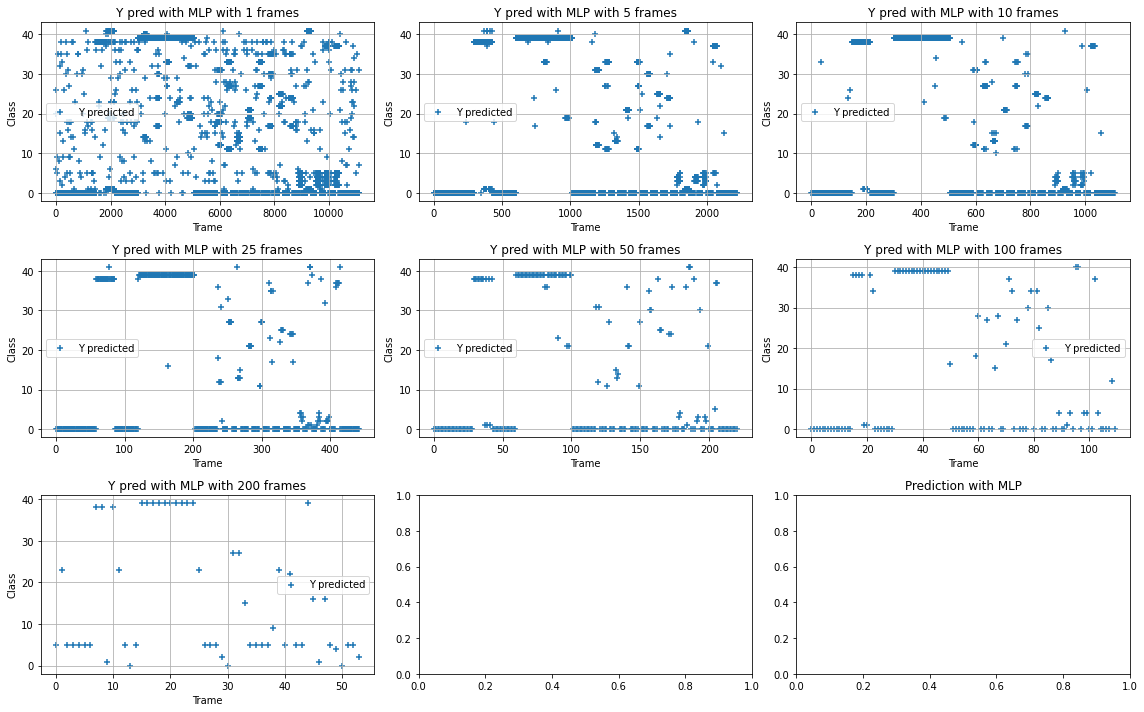

In [72]:
plot_multiple_prediction(y_tests_mlp_noise, nrows = 3, ncols=3, name = 'MLP')

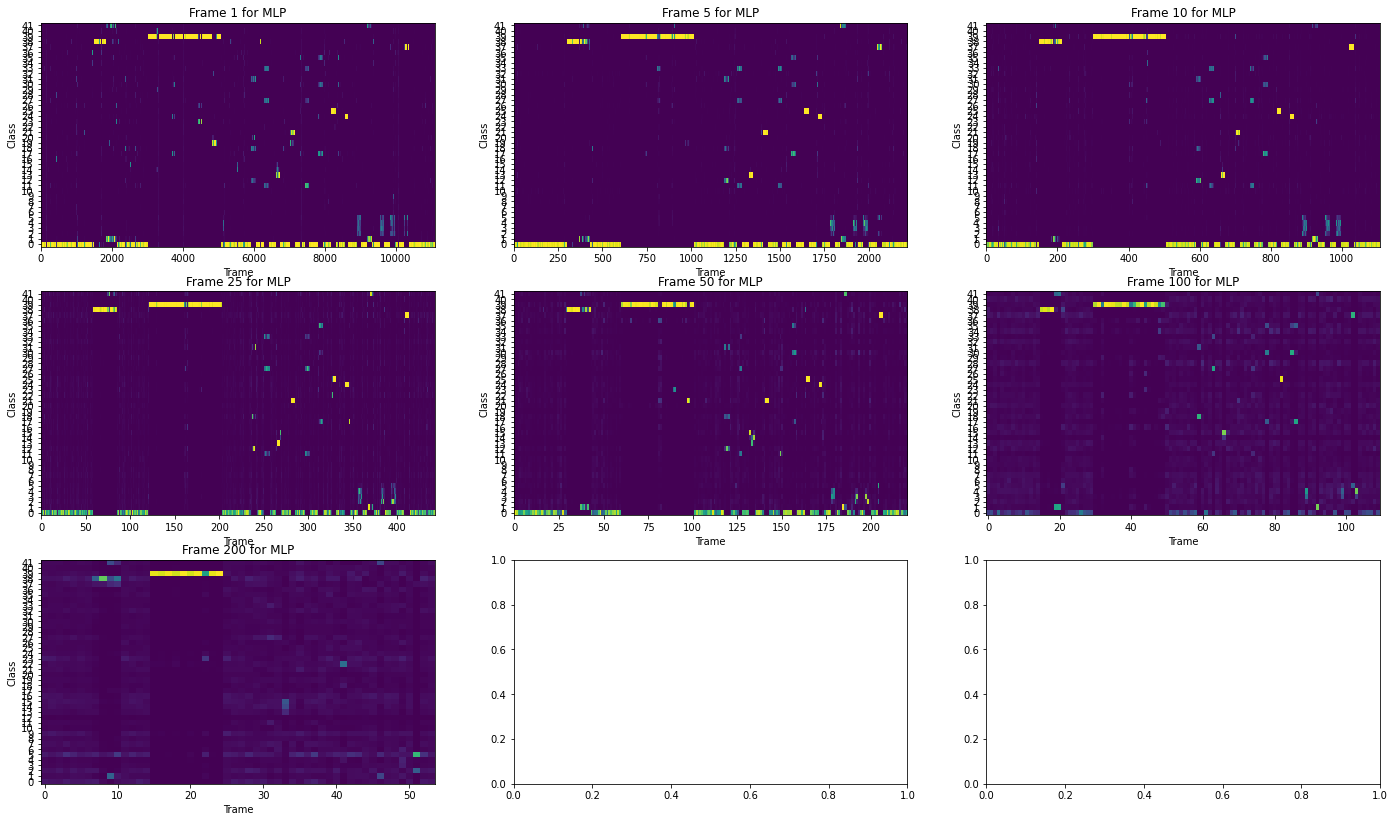

In [73]:
plot_proba(y_tests_mlp_noise_proba, nrows = 3, ncols = 3, name = 'MLP')

### GRU 

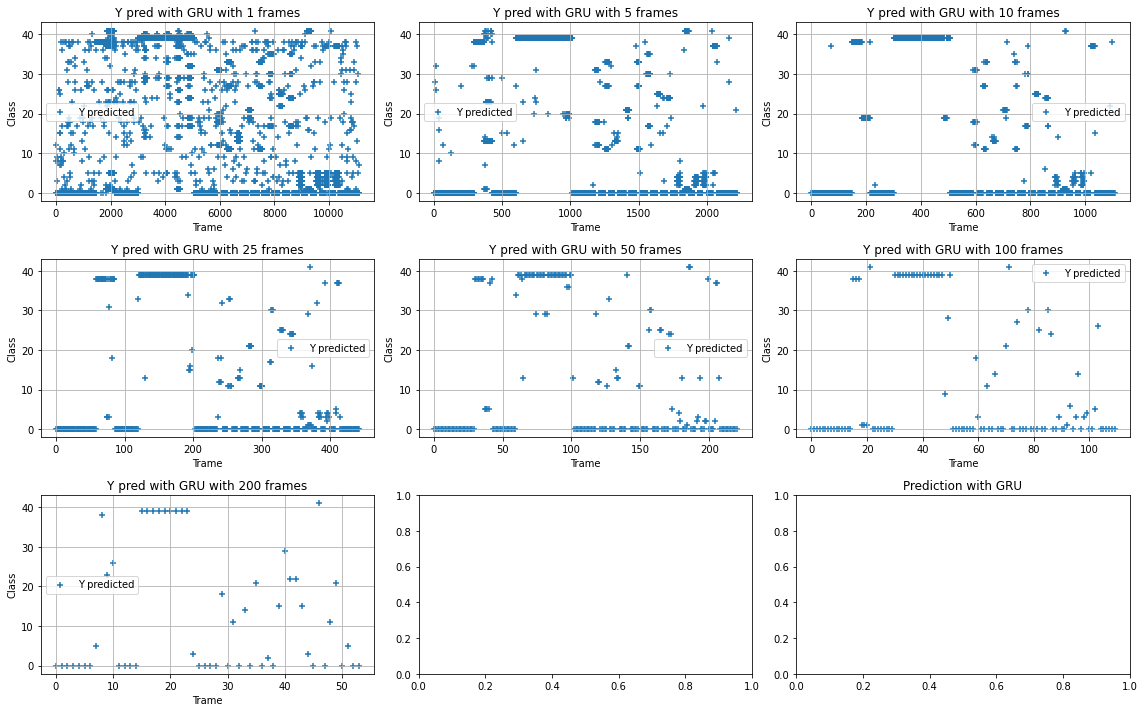

In [74]:
plot_multiple_prediction(y_tests_gru_noise, nrows = 3, ncols=3, name = 'GRU')

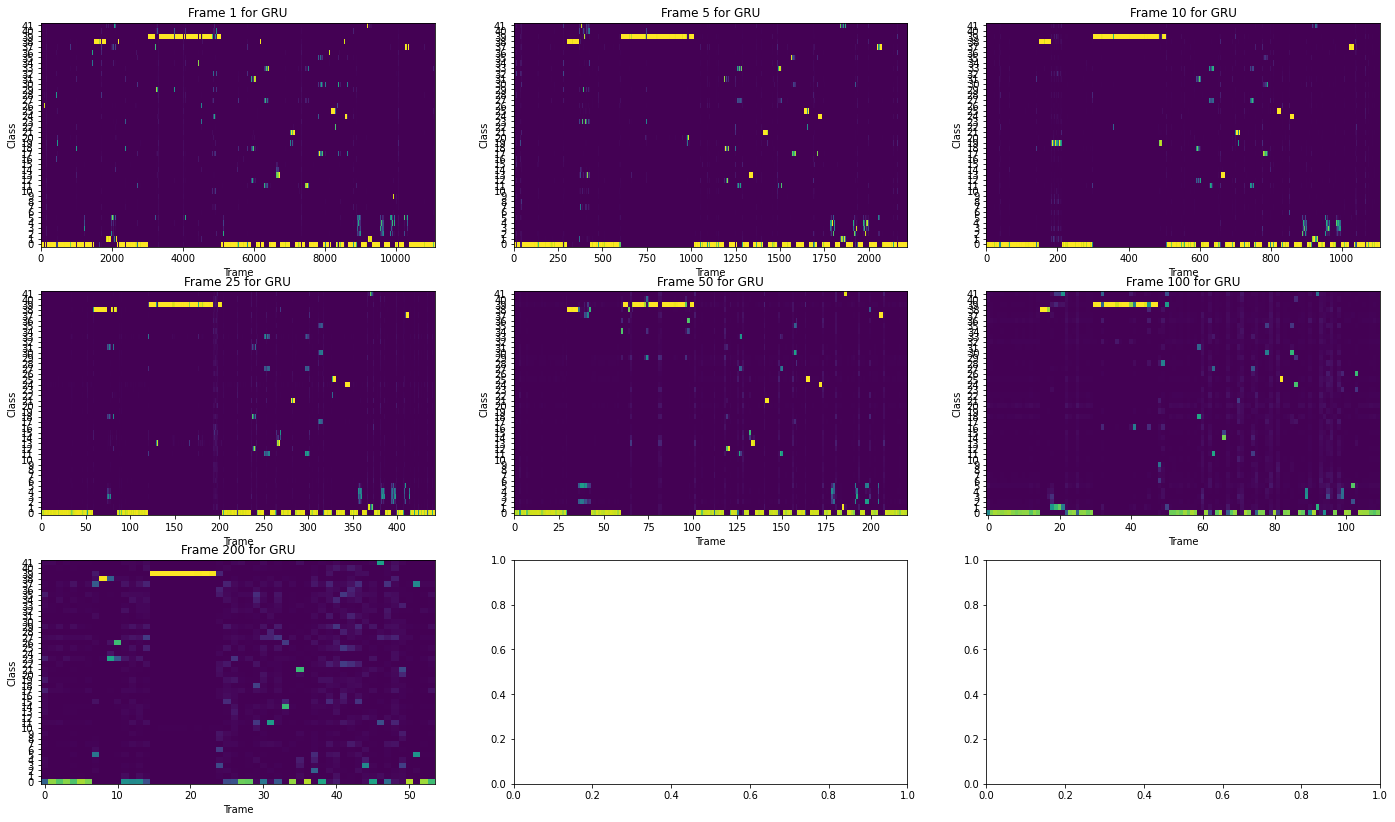

In [75]:
plot_proba(y_tests_gru_noise_proba, nrows = 3, ncols = 3, name = 'GRU')